In [6]:
import matplotlib.pyplot as plt
import urllib.request, json
import tensorflow as tf
import numpy as np
import pandas
from collections import Counter

from fontTools.misc.cython import returns
from markdown_it.rules_core.normalize import NULL_RE
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import RegexpTokenizer
from tensorflow.python.ops.gen_special_math_ops import bessel_y0_eager_fallback

tokenizer = RegexpTokenizer(r'\w+')
import pickle

In [16]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
plt.rcParams['figure.figsize'] = (8, 8)
plt.rc('font', size=8)

Num GPUs Available:  1


In [8]:
def converteTextoParaTokens(texto : str):
    tokens = list(map(lambda x: str(x).lower(), tokenizer.tokenize(texto)))
    for i in range(len(tokens)):
        if tokens[i].isdigit():
            tokens[i] = "num"
    return tokens

In [5]:
'''
res = urllib.request.urlopen("http://127.0.0.1:8000/api/vagas?treinamento=true")
data = json.loads(res.read())
exemplos_treinamento = data['data']
qtd_pos = data['qtd_pos']
qtd_neg = data['qtd_neg']

pickle.dump(exemplos_treinamento, file = open("exemplos.pickle", "wb"))
pickle.dump(qtd_pos, file = open("qtd_pos.pickle", "wb"))
pickle.dump(qtd_neg, file = open("qtd_neg.pickle", "wb"))
'''

In [9]:
exemplos_treinamento = pickle.load(open("exemplos.pickle", "rb"))
qtd_pos = pickle.load(open("qtd_pos.pickle", "rb"))
qtd_neg = pickle.load(open("qtd_neg.pickle", "rb"))

In [10]:
from collections import OrderedDict

histograma = []

for exemplo in exemplos_treinamento:
    txtVaga = exemplo['txtVaga']
    tokens = converteTextoParaTokens(txtVaga)
    histograma += tokens

frequencia_tokens = Counter(histograma)
frequencia_tokens = OrderedDict(frequencia_tokens.most_common())
frequencia_tokens = {k: c for k, c in frequencia_tokens.items() if c > 5}
print(len(frequencia_tokens))
df = pandas.DataFrame.from_dict(frequencia_tokens, orient='index')
#df.plot(kind='bar')

1428


In [11]:
sentences = []
pos = []
maxlen = 46

for exemplo in exemplos_treinamento:
    tokens = converteTextoParaTokens(exemplo['txtVaga'])
    aplicacao = exemplo['isApplied']
    sentences.append(tokens)
    pos.append([int(bool(aplicacao))])
    
    if len(tokens) > maxlen:
        maxlen = len(tokens)
        print("Maxlen atualizado: ",  maxlen)

In [12]:
UNKNOWN_IDX = len(frequencia_tokens) - 1
word_list = ['<pad>'] + list(frequencia_tokens.keys()) + ['_UNKNOWN']
word2idx = {word:idx for idx, word in enumerate(word_list)}
idx2word = {idx:word for idx, word in enumerate(word_list)}
pos_list = sorted(set(sum(pos, [])))
pos2idx = {pos:idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx:pos for idx, pos in enumerate(pos_list)}
X = list(map(lambda sentence: [word2idx.get(token) or UNKNOWN_IDX for token in sentence], sentences))
y = list(map(lambda sentence: [pos2idx.get(token) for token in sentence], pos))
X = pad_sequences(X, maxlen=maxlen, padding='post')
X_mask = (X != 0).astype(np.float32)
X_len = np.array(list((map(lambda sentence: len(sentence), sentences))), dtype=np.float32)
y = pad_sequences(y, maxlen=1, padding='post')

json_str = json.dumps(word2idx, ensure_ascii=False)
json_str = json.loads(json_str)
with open('char2idx.json', 'w', encoding='utf-8') as json_file:
    json.dump(json_str, json_file, ensure_ascii=False)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - auc: 0.7908 - fn: 33.7500 - fp: 2684.1001 - loss: 0.5333
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - auc: 0.9629 - fn: 5.7500 - fp: 1282.9500 - loss: 0.2397
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - auc: 0.9814 - fn: 4.9000 - fp: 817.4500 - loss: 0.1754
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - auc: 0.9892 - fn: 3.5500 - fp: 526.7000 - loss: 0.1121
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - auc: 0.9932 - fn: 2.1000 - fp: 458.5000 - loss: 0.0876
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - auc: 0.9945 - fn: 1.2500 - fp: 324.4500 - loss: 0.0676
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - auc: 0.9958 - fn: 0.0000e+00 - fp: 316.5500 - loss: 0.0627
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - auc: 0.9965 - fn: 0.0000e+00 - fp: 248.9500 - loss: 0.0500
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - auc: 0.9971 - fn: 0.4500 - fp: 207.2500 - loss: 0.0440
Epoch 10/50
19/19

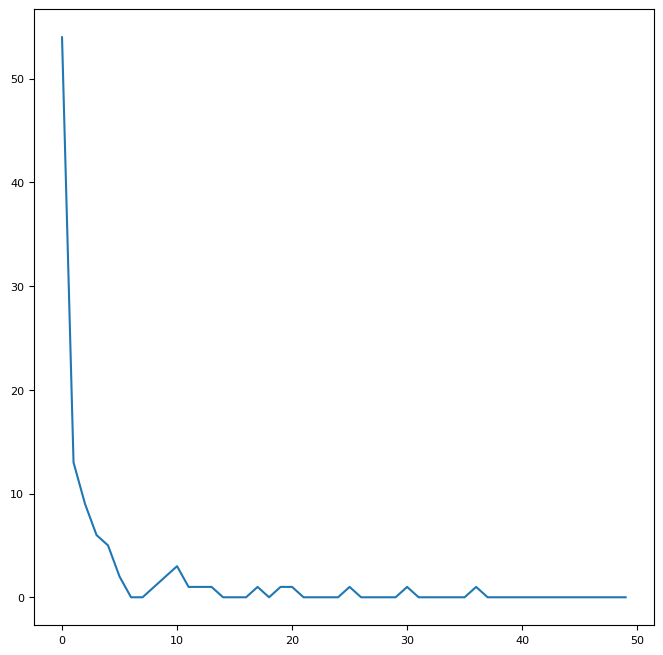

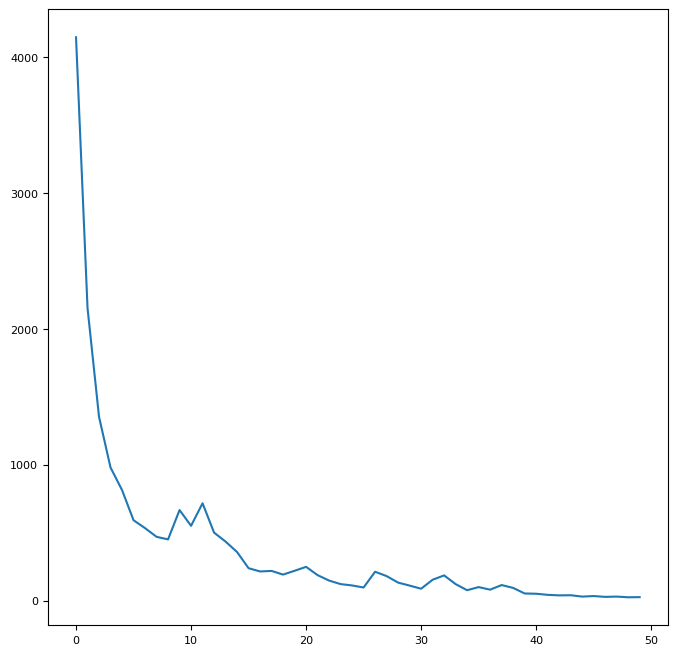

In [32]:
num_classes = len(pos2idx)
input_dim = len(word2idx)
output_dim = len(word2idx)
exemples_dim = len(sentences)
batch_size = 1000
epochs = 50

optimizer = Adam()

loss_function = BinaryCrossentropy()
additional_metrics = [
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.AUC(name='auc')
]

model = Sequential()
model.add(Embedding(
    input_dim=input_dim,
    output_dim=output_dim,
    mask_zero=True,
    embeddings_initializer=tf.keras.initializers.random_normal
))
model.add(SimpleRNN(units=64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
#model.summary()

weight_for_0 = (1 / qtd_neg) * (exemples_dim / 2.0)
weight_for_1 = (1 / qtd_pos) * (exemples_dim / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

history = model.fit(X, y, class_weight=class_weight, batch_size=batch_size, shuffle=True, epochs=epochs, verbose=True)

plt.figure()
plt.plot(history.history['fn'])
plt.show()

plt.figure()
plt.plot(history.history['fp'])
plt.show()

In [33]:
model.save("model.keras")

UsageError: Line magic function `%tensorboard` not found.
